VAE based on the paper Deep Dynamical Modeling and Control of Unstead Fluid Flows: https://arxiv.org/pdf/1805.07472.pdf

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate

import torch 
import torch.nn as nn

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
def lorenz(t, x): # x is coordinates (x,y,z)
    return np.array([10*(x[1]-x[0]), x[0]*(28-x[2]) - x[1], x[0]*x[1] - 2.667*x[2]])

In [4]:
t = np.linspace(0, 20, num=2000)  # (500,)

In [5]:
def trajectory(x_0):
    lorenz_attractor = integrate.solve_ivp(lorenz, (0.0,20), np.array(x_0), t_eval=t)
    trajectory = torch.tensor(np.transpose(lorenz_attractor['y']), dtype=torch.float)
    return trajectory

In [6]:
data = trajectory([-1.0, 0.0, 0.0])
data.shape

torch.Size([2000, 3])

In [7]:
x_traj = data[:, 0]
y_traj = data[:, 1]
z_traj = data[:, 2]

D:\Programs\Anaconda3\lib\site-packages\mpl_toolkits\mplot3d\proj3d.py:189: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([xs, ys, zs, np.ones_like(xs)])


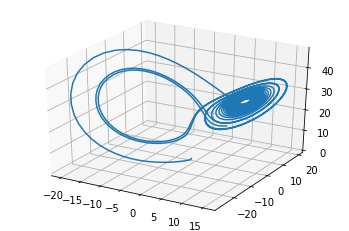

In [8]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot(x_traj, y_traj, z_traj)

In [9]:
data = data.to(device)

In [ ]:
'''
x = trajectory[0:n]    # (3, n)
y = trajectory[1:n+1]  # (3, n)

# encoding

x_ = g(x)
y_ = g(y)

A = y_ * moore_penrose_inverse(x_)

loss = (y_ - A * x_) ** 2

y_pred = A * x_

# decoding

X = decoder(x_)   # decoder is inverse of g


Y = decoder(y_pred)

loss = (x - X)**2 + (y - Y)**2
'''

In [18]:
class VAE(torch.nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
        self.enc1 = nn.Linear(3, 25)
        self.enc2 = nn.Linear(25, 5)
        self.enc3 = nn.Linear(5, 2)
        
        self.dec1 = nn.Linear(2, 25)
        self.dec2 = nn.Linear(25, 5)
        self.dec3 = nn.Linear(5, 3)
        
    def encode(self, x):
        x = torch.tanh(self.enc1(x))
        x = torch.tanh(self.enc2(x))
        return self.enc3(x)
    
    def decode(self, x):
        x = torch.tanh(self.dec1(x))
        x = torch.tanh(self.dec2(x))
        return self.dec3(x)
        
    def forward(self, traj):  # (num_steps, state)
        # split trajectory into "shifted" versions
        n = traj.shape[0]
        x = traj[:n-1]
        y = traj[1:n]
        
        # transpose so that A comes out with the right shape
        x_ = torch.transpose(self.encode(x), 0, 1)  # (reduced_state, num_steps-1)
        y_ = torch.transpose(self.encode(y), 0, 1)
        
        # split x, y in half
        x_train, x_test = torch.split(x_, n//2, dim=1)
        y_train, y_test = torch.split(y_, n//2, dim=1)
        
        # calculate A with the Moore-Penrose inverse
        # calculate A using only first half of trajectory
        A = torch.matmul(y_train, torch.pinverse(x_train))  # (reduced_state, reduced_state)
        
        x_0 = x_.narrow(1, 0, 1)  # (reduced_state, 1)
        y_pred = torch.matmul(A, x_0)  # (reduced_state, 1) 
        
        # recursively multiply x_0 by A to predict y_
        for i in range(n-2):
            y_pred_n = torch.matmul(A, y_pred.narrow(1, i, 1))
            y_pred = torch.cat((y_pred, y_pred_n), 1)
            
        # y_pred should have shape (reduced_state, num_steps-1)
            
        # un-transpose and decode
        x_ = torch.transpose(x_, 0, 1)  # (num_steps-1, reduced_state)
        y_pred = torch.transpose(y_pred, 0, 1)
        
        X = self.decode(x_)  # (num_steps-1, full_state)
        Y = self.decode(y_pred)
        
        return X, Y

In [19]:
autoencoder = VAE().to(device)

In [20]:
optim = torch.optim.Adam(autoencoder.parameters(), lr=0.002)
loss = nn.MSELoss()

n = data.shape[0]
x = data[:n-1]
y = data[1:n]

loss_history = []

for i in range(800):
    optim.zero_grad()
    
    X, Y = autoencoder(data)
    
    l = loss(x, X) + loss(y, Y)
    l.backward()
    optim.step()
    
    loss_history.append(l)

Text(0, 0.5, 'Loss')

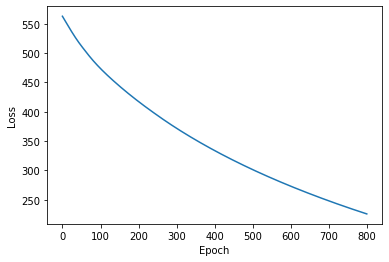

In [21]:
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')